In [75]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm 
from matplotlib import pyplot as plt

In [76]:
node_feats = np.load('/home/ayush/DyGLib/DG_data/uci/ml_uci_node.npy')
num_nodes = node_feats.shape[0]

In [77]:
edge_data = pd.read_csv('/home/ayush/DyGLib/DG_data/uci/ml_uci.csv')

In [80]:
def calculate_correlation(old_deg, new_node_new_deg):
  return float(torch.corrcoef(torch.cat((old_deg.unsqueeze(0), new_node_new_deg.unsqueeze(0)), dim = 0))[0, 1])

In [103]:
def calculate_all_correlations(node1, node2, ts, num_nodes, total_time, t1_factor = 0.05, t2_factor = 0.05):
  t1 = t1_factor * total_time
  t2 = t2_factor * total_time
  # indices corresponding to:
  p1 = 0  # start of the subgraph [t-t1-t2, t-t2)
  p2 = 0  # end of the subgraph [t-t1-t2, t-t2) and start of the subgraph [t-t2, t]
  p3 = 0  # end of the subgraph [t-t2, t]
  old_deg = torch.zeros(num_nodes)              # corresponds to the `degree` of each node in the subgraph [t-t1-t2, t-t2)
  new_node_new_deg = torch.zeros(num_nodes)     # corresponds to the `new node neighbor degree` of each node in the subgraph [t-t2, t]
  is_a_new_node = torch.ones(num_nodes, dtype=torch.bool)        # 1 if the node is unseen yet 0 otherwise
  is_a_new_node_edge = []   # stores is_a_new_node tuple for both the new nodes in [t-t2, t] subgraph
  correlations = []
  times = []
  is_first_time = True
  
  # Moving p3 from old timestamp to the next timestamp
  with tqdm(total=len(ts)) as pbar:
    while(p3 < len(ts)-1):
      if is_first_time:
        while(ts[p3] < t1 + t2):
          # Since this edge is entering the new subgraph [t-t2, t]
          # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
          is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
          # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
          new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
          new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
          # Mark the nodes as seen
          is_a_new_node[node1[p3]] = False
          is_a_new_node[node2[p3]] = False
          # Move the counter ahead
          p3 += 1
          pbar.update(1)
        is_first_time = False
      else:
        # Since this edge is entering the new subgraph [t-t2, t]
        # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
        is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
        # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
        new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
        new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
        # Mark the nodes as seen
        is_a_new_node[node1[p3]] = False
        is_a_new_node[node2[p3]] = False
        # Move the counter ahead
        p3 += 1
        pbar.update(1)
      
      while(ts[p2] < ts[p3]-t2):
        # Since this edge is going to the old subgraph [t-t1-t2, t-t2), add to the old_deg
        old_deg[node1[p2]] += 1
        old_deg[node2[p2]] += 1
        # Since this edge is coming from the new subgraph [t-t2, t]
        # If the other node was seen first at this edge (as indicated by the first element in `is_a_new_node_edge`, 
        # then remove 1 from the new_node_new_deg of this node)
        new_node_new_deg[node1[p2]] -= int(is_a_new_node_edge[0][1])
        new_node_new_deg[node2[p2]] -= int(is_a_new_node_edge[0][0])
        # Remove this edge from `is_a_new_node_edge` since it is no longer in the new subhraph [t-t2, t]
        is_a_new_node_edge = is_a_new_node_edge[1:]
        # Move the counter ahead
        p2 += 1
        
      while(ts[p1] < ts[p3]-t1-t2):
        # Since these edges are being removed from the old subgraph [t-t1-t2, t-t2), decrease old subgraph degree
        old_deg[node1[p1]] -= 1
        old_deg[node2[p1]] -= 1
        # Move the counter ahead
        p1 += 1
      
      correlations.append(calculate_correlation(old_deg, new_node_new_deg))
      times.append(ts[p3])
    return times, correlations

In [104]:
def calculate_correlation_plots(data_name = "wikipedia"):
  node_feats = np.load(f'/home/ayush/DyGLib/DG_data/{data_name}/ml_{data_name}_node.npy')
  num_nodes = node_feats.shape[0]
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/DG_data/{data_name}/ml_{data_name}.csv')
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  
  # Check if they are sorted based on time
  new_ts = ts.clone().tolist()
  new_ts = sorted(new_ts)
  assert np.count_nonzero(np.array([new_ts[i] == ts[i] for i in range(len(ts))])) == len(ts)
  
  # Check if num_nodes is correct
  assert num_nodes == max(max(node1), max(node2)) + 1

  total_time = ts[-1] - ts[0]
  times, correlations = calculate_all_correlations(node1=node1, node2=node2, ts=ts, num_nodes=num_nodes, total_time=total_time, t1_factor = 0.05, t2_factor = 0.05)
  plt.plot(torch.arange(0, len(correlations)), correlations)
  plt.title(f'Correlation b/w old degree and new node neighbor degree for {data_name}')
  plt.show()

100%|█████████▉| 157473/157474 [00:37<00:00, 4228.98it/s]


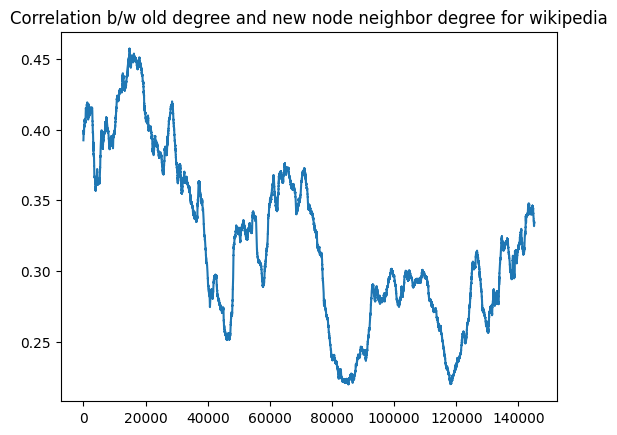

In [105]:
calculate_correlation_plots("wikipedia")

100%|█████████▉| 672446/672447 [03:22<00:00, 3320.33it/s]


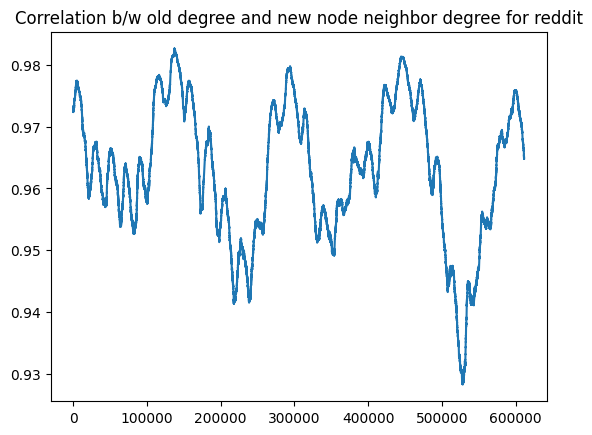

In [106]:
calculate_correlation_plots("reddit")